In [1]:
import numpy as np 
import pandas as pd 
import os
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import random_split, DataLoader
from collections import Counter
from torch import optim
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
# Reading the dataset after normalizing, converting to tensor and converting each to a standard size
dataset = datasets.ImageFolder('./data/', transform = transforms.Compose([
    transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))

In [3]:
# Converting the train, val, test split
trainSize = int(0.8*len(dataset))
valSize = (len(dataset) - trainSize)//2
testSize = len(dataset) - trainSize - valSize

trainData, valData, testData = random_split(dataset, [trainSize, valSize, testSize])

trainClasses = [dataset.targets[i] for i in (trainData.indices)]
print('train', Counter(trainClasses))
testClasses = [dataset.targets[i] for i in (testData.indices)]
print('test', Counter(testClasses))
valClasses = [dataset.targets[i] for i in (valData.indices)]
print('val', Counter(valClasses))

print(len(trainData), len(valData), len(testData))

# entering the data into dataloaders
train_loader = DataLoader(trainData, 128, shuffle = True)
test_loader = DataLoader(testData, 128, shuffle = True)
valid_loader = DataLoader(valData, 128, shuffle = True)

train Counter({1: 11055, 0: 10991})
test Counter({0: 1383, 1: 1373})
val Counter({0: 1405, 1: 1351})
22046 2756 2756


## Part 1

In [27]:
def imshow(img):
    '''
    Function to display the image
    '''
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
classes=['infected','uninfected']

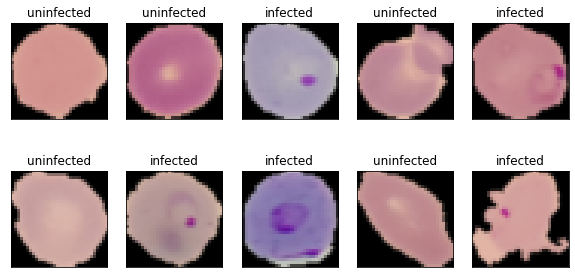

In [29]:
infected = 0
uninfected = 0
fig = plt.figure(figsize=(10, 5))
ctr = 1
for i in range(len(trainData)):
    if infected == 5 and uninfected == 5:
        break
    if trainData[i][1] == 0:
        if infected == 5:
            continue
        infected += 1
    else:
        if uninfected == 5:
            continue
        uninfected += 1
    ax = fig.add_subplot(2, 5, ctr, xticks=[], yticks=[])
    ctr += 1
    imshow(np.array(trainData[i][0]))
    ax.set_title(classes[trainData[i][1]])

In [30]:
def lossVsEpochPlot(trainLoss, validLoss):
    """
    Plot the loss vs epoch plot
    trainLoss: train loss
    validLoss: valid loss
    """
    plt.plot(trainLoss, label="Train Loss", color="blue")
    plt.plot(validLoss, label="Validation Loss", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.show()

## Part 2

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv2=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv3=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64,1)
        
    def forward(self, x):        
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.pool3(F.relu(self.conv3(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.fc1(x))
        return x

In [8]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [14]:
n_epochs = 10
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.334640 	Validation Loss: 0.325175


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.288886 	Validation Loss: 0.277849


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.255217 	Validation Loss: 0.275607


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.233331 	Validation Loss: 0.228310


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.206191 	Validation Loss: 0.203853


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.192272 	Validation Loss: 0.191669


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.176076 	Validation Loss: 0.187682


  1%|          | 1/173 [00:00<00:34,  5.04it/s]

Epoch: 8 	Training Loss: 0.170999 	Validation Loss: 0.192674


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.165569 	Validation Loss: 0.181577


100%|██████████| 173/173 [00:38<00:00,  4.52it/s]


Epoch: 10 	Training Loss: 0.156583 	Validation Loss: 0.192234


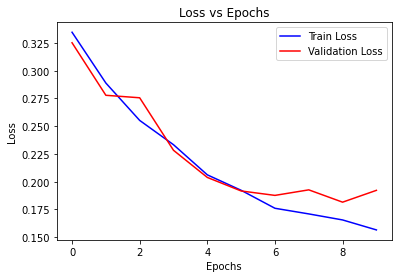

In [17]:
lossVsEpochPlot(trainLoss, validLoss)

In [18]:
torch.save(model.state_dict(), "Models/basicCNN.pt")

In [24]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:04<00:00,  4.61it/s]

Accuracy of the network on 2756 test images: 93.51%


## Part 3 | Weight Initialization

In [81]:
class CNN_zero(nn.Module):
    def __init__(self, weightInit='he'):
        super(CNN_zero, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.blockA.weight.data.fill_(0.00)
        self.blockA.bias.data.fill_(0.00)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.blockB.weight.data.fill_(0.00)
        self.blockB.bias.data.fill_(0.00)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.blockC.weight.data.fill_(0.00)
        self.blockC.bias.data.fill_(0.00)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        self.fc1.weight.data.fill_(0.00)
        self.fc1.bias.data.fill_(0.00)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.fc1(x))
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

### Zero Weight

In [82]:
model = CNN_zero(weightInit = 'zero').to(device)
print(model)

CNN_zero(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [83]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [84]:
n_epochs = 5
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  1%|          | 1/173 [00:00<00:28,  5.99it/s]

Epoch: 1 	Training Loss: 0.693152 	Validation Loss: 0.693160


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.693150 	Validation Loss: 0.693167


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.693152 	Validation Loss: 0.693175


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.693147 	Validation Loss: 0.693182


100%|██████████| 173/173 [00:38<00:00,  4.49it/s]


Epoch: 5 	Training Loss: 0.693150 	Validation Loss: 0.693180


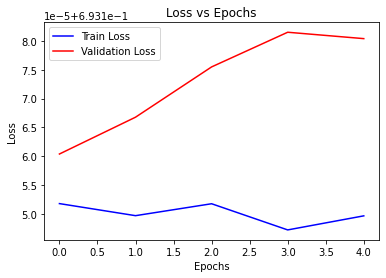

In [85]:
lossVsEpochPlot(trainLoss, validLoss)

In [86]:
torch.save(model.state_dict(), "Models/CNN_weight_zero.pt")

In [87]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:04<00:00,  4.70it/s]

Accuracy of the network on 2756 test images: 49.82%


### Random Weight

In [90]:
np.random.normal()

-0.5411842647216074

In [97]:
class CNN_random(nn.Module):
    def __init__(self, weightInit='he'):
        super(CNN_random, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.blockA.weight.data.fill_(np.random.normal())
        self.blockA.bias.data.fill_(np.random.normal())
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.blockB.weight.data.fill_(np.random.normal())
        self.blockB.bias.data.fill_(np.random.normal())
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.blockC.weight.data.fill_(np.random.normal())
        self.blockC.bias.data.fill_(np.random.normal())
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        self.fc1.weight.data.fill_(np.random.normal())
        self.fc1.bias.data.fill_(np.random.normal())
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.fc1(x))
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

In [98]:
model = CNN_random('random').to(device)
print(model)

CNN_random(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [99]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [100]:
n_epochs = 5
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.502464 	Validation Loss: 1.329508


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.497849 	Validation Loss: 1.324739


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.494032 	Validation Loss: 1.320799


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.490851 	Validation Loss: 1.317422


100%|██████████| 173/173 [00:38<00:00,  4.53it/s]


Epoch: 5 	Training Loss: 1.488284 	Validation Loss: 1.314682


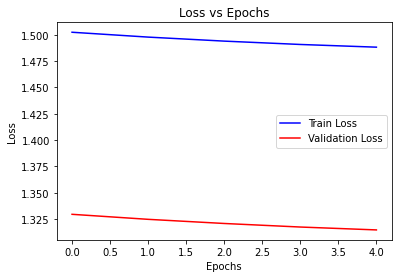

In [101]:
lossVsEpochPlot(trainLoss, validLoss)

In [102]:
torch.save(model.state_dict(), "Models/CNN_weight_random.pt")

In [103]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:04<00:00,  4.97it/s]

Accuracy of the network on 2756 test images: 49.82%


### He Initialization

In [106]:
class CNN_he(nn.Module):
    def __init__(self, weightInit='he'):
        super(CNN_he, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        torch.nn.init.kaiming_normal_(self.blockA.weight)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        torch.nn.init.kaiming_normal_(self.blockB.weight)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.blockC.weight)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.fc1(x))
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

In [107]:
model = CNN_he('he').to(device)
print(model)

CNN_he(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [108]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [109]:
n_epochs = 5
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.578978 	Validation Loss: 0.518942


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.455706 	Validation Loss: 0.468347


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.389639 	Validation Loss: 0.364235


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.348936 	Validation Loss: 0.370820


100%|██████████| 173/173 [00:38<00:00,  4.52it/s]


Epoch: 5 	Training Loss: 0.316573 	Validation Loss: 0.309512


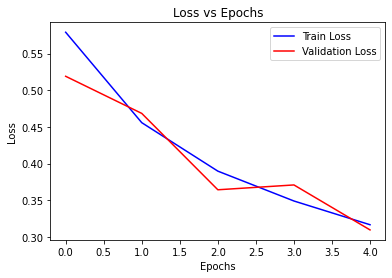

In [110]:
lossVsEpochPlot(trainLoss, validLoss)

In [111]:
torch.save(model.state_dict(), "Models/CNN_weight_he.pt")

In [112]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:04<00:00,  4.57it/s]

Accuracy of the network on 2756 test images: 86.90%


## Part 4 | Dropout

### Between convolution layers

In [160]:
class CNN_dropout_convolution(nn.Module):
    def __init__(self):
        super(CNN_dropout_convolution, self).__init__()
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        torch.nn.init.kaiming_normal_(self.blockA.weight)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        torch.nn.init.kaiming_normal_(self.blockB.weight)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.blockC.weight)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.dropout(x)
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.dropout(x)
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.fc1(x))
        return x

In [161]:
model = CNN_dropout_convolution().to(device)
print(model)

CNN_dropout_convolution(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [162]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [163]:
n_epochs = 10
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.702863 	Validation Loss: 0.613889


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.570249 	Validation Loss: 0.535954


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.491683 	Validation Loss: 0.462501


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.433541 	Validation Loss: 0.421316


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.394193 	Validation Loss: 0.371187


  1%|          | 1/173 [00:00<00:31,  5.54it/s]

Epoch: 6 	Training Loss: 0.358360 	Validation Loss: 0.340045


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.333927 	Validation Loss: 0.327859


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.314743 	Validation Loss: 0.296371


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.295758 	Validation Loss: 0.285140


100%|██████████| 173/173 [00:43<00:00,  4.00it/s]


Epoch: 10 	Training Loss: 0.275823 	Validation Loss: 0.270002


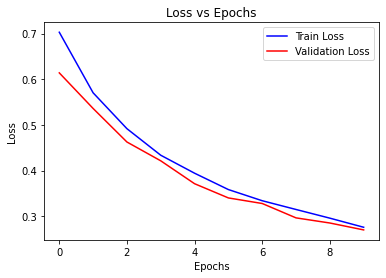

In [164]:
lossVsEpochPlot(trainLoss, validLoss)

In [165]:
torch.save(model.state_dict(), "Models/CNN_dropout_conv.pt")

In [166]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:05<00:00,  4.21it/s]

Accuracy of the network on 2756 test images: 90.82%


### After fc layer

In [126]:
class CNN_dropout_fc(nn.Module):
    def __init__(self):
        super(CNN_dropout_fc, self).__init__()
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        torch.nn.init.kaiming_normal_(self.blockA.weight)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        torch.nn.init.kaiming_normal_(self.blockB.weight)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.blockC.weight)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.dropout(self.fc1(x)))
        return x

In [127]:
model = CNN_dropout_fc().to(device)
print(model)

CNN_dropout_fc(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [128]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [129]:
n_epochs = 10
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  1%|          | 1/173 [00:00<00:31,  5.50it/s]

Epoch: 1 	Training Loss: 0.620591 	Validation Loss: 0.538709


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.555404 	Validation Loss: 0.490745


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.524320 	Validation Loss: 0.419068


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.495778 	Validation Loss: 0.385649


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.470477 	Validation Loss: 0.361317


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.457484 	Validation Loss: 0.339018


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.429275 	Validation Loss: 0.310848


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.419732 	Validation Loss: 0.292769


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.411277 	Validation Loss: 0.277031


100%|██████████| 173/173 [00:42<00:00,  4.03it/s]


Epoch: 10 	Training Loss: 0.400504 	Validation Loss: 0.265724


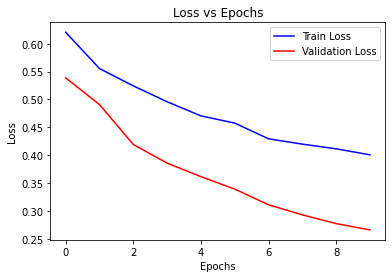

In [130]:
lossVsEpochPlot(trainLoss, validLoss)

In [131]:
torch.save(model.state_dict(), "Models/CNN_dropout_fc.pt")

In [132]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:04<00:00,  4.45it/s]

Accuracy of the network on 2756 test images: 89.73%


## Part 5 | Regularization

### L1 Regularization

In [153]:
class CNN_l1(nn.Module):
    def __init__(self):
        super(CNN_l1, self).__init__()
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        torch.nn.init.kaiming_normal_(self.blockA.weight)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        torch.nn.init.kaiming_normal_(self.blockB.weight)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.blockC.weight)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.dropout(self.fc1(x)))
        return x

In [154]:
model = CNN_l1().to(device)
print(model)

CNN_l1(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [155]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [156]:
n_epochs = 10
l1_lambda = 1e-3
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.741764 	Validation Loss: 2.403896


  1%|          | 1/173 [00:00<00:29,  5.79it/s]

Epoch: 2 	Training Loss: 2.184911 	Validation Loss: 1.905637


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.802272 	Validation Loss: 1.579499


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.539570 	Validation Loss: 1.349934


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.357646 	Validation Loss: 1.214155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.212741 	Validation Loss: 1.065280


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.097933 	Validation Loss: 0.974204


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.013855 	Validation Loss: 0.891790


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.945763 	Validation Loss: 0.818743


100%|██████████| 173/173 [00:43<00:00,  3.98it/s]


Epoch: 10 	Training Loss: 0.883097 	Validation Loss: 0.768687


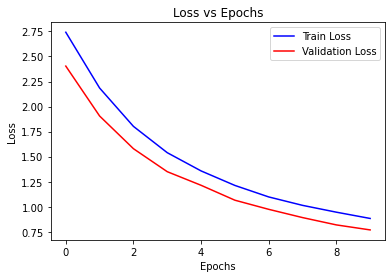

In [157]:
lossVsEpochPlot(trainLoss, validLoss)

In [158]:
torch.save(model.state_dict(), "Models/CNN_l1.pt")

In [159]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

Accuracy of the network on 2756 test images: 85.78%


# L2 Regularization

In [146]:
class CNN_l2(nn.Module):
    def __init__(self):
        super(CNN_l2, self).__init__()
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        torch.nn.init.kaiming_normal_(self.blockA.weight)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        torch.nn.init.kaiming_normal_(self.blockB.weight)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        torch.nn.init.kaiming_normal_(self.blockC.weight)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64, 1)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape(-1,1*1*64)
        x=torch.sigmoid(self.dropout(self.fc1(x)))
        return x

In [147]:
model = CNN_l2().to(device)
print(model)

CNN_l2(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [148]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

In [149]:
n_epochs = 10
trainLoss = []
validLoss = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.611686 	Validation Loss: 0.516180


  1%|          | 1/173 [00:00<00:31,  5.43it/s]

Epoch: 2 	Training Loss: 0.547295 	Validation Loss: 0.476349


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.510084 	Validation Loss: 0.420284


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.495345 	Validation Loss: 0.390082


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.478925 	Validation Loss: 0.380822


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.467203 	Validation Loss: 0.340709


  1%|          | 1/173 [00:00<00:32,  5.25it/s]

Epoch: 7 	Training Loss: 0.457494 	Validation Loss: 0.343635


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.437656 	Validation Loss: 0.320421


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.423090 	Validation Loss: 0.309022


100%|██████████| 173/173 [00:42<00:00,  4.10it/s]


Epoch: 10 	Training Loss: 0.422061 	Validation Loss: 0.287807


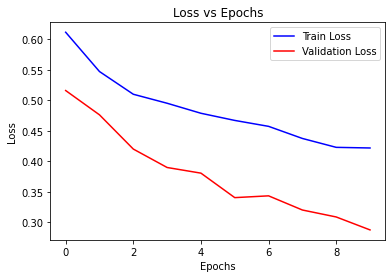

In [150]:
lossVsEpochPlot(trainLoss, validLoss)

In [151]:
torch.save(model.state_dict(), "Models/CNN_l2.pt")

In [152]:
model.eval()
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    acc = sum(output.reshape(-1).detach().round() == target)
    nSamples += target.shape[0]
    nCorrect += acc
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on {nSamples} test images: {acc:.2f}%')

100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

Accuracy of the network on 2756 test images: 89.40%
